## Chapter 20 - Metric Predicted Variable with Multiple Nominal Predictors

- [20.2 - Hierarchical Bayesian Approach](#20.2---Hierarchical-Bayesian-Approach)
 - [20.2.3 - Main effect contrasts](#20.2.3---Main-effect-contrasts)
- [20.4 - Heterogenous Variances and Robustness against Outliers](#20.4---Heterogenous-Variances-and-Robustness-against-Outliers)
- 20.5 - Within-Subject Designs
 - [20.5.2 Split-plot design](#20.5.2---Split-plot-design)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

In [2]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [3]:
def plot_mustache(var, sd, j, width=.75, ax=None):
    for i in np.arange(0, len(var), int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        ax.plot(-xrange_scaled+j, yrange, color=color, alpha=.6, zorder=99)

### 20.2 - Hierarchical Bayesian Approach

In [4]:
df = pd.read_csv('data/Salary.csv', usecols=[0,3,5], dtype={'Org': 'category', 'Pos': 'category'})

# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 3 columns):
Org       1080 non-null category
Pos       1080 non-null category
Salary    1080 non-null int64
dtypes: category(2), int64(1)
memory usage: 13.8 KB


In [5]:
df.groupby('Pos').apply(lambda x: x.head(2))

Org      Pos  Salary
Pos                               
Assis   4    LGED    Assis   63796
        6    INFO    Assis   98814
Assoc   0      PL    Assoc   72395
        1    MUTH    Assoc   61017
Full    7    CRIN     Full  107745
        9     PSY     Full  173302
Endow   5    MGMT    Endow  219600
        8    CRIN    Endow  114275
Disting 29   SPEA  Disting  285000
        128  MUHI  Disting  114189

#### Model (Kruschke, 2015)

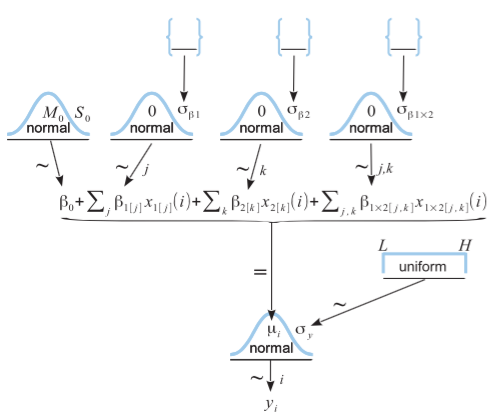

In [6]:
Image('images/fig20_2.png')

Reparameterization of the model results in much more efficient and faster sampling.  
See http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/ and  
http://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html

In [91]:
y = df.Salary
yMean = y.mean()
ySD = y.std()

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD)

with pm.Model() as model1:
    
    #a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0, sd=1)
    a0 = pm.Deterministic('a0', yMean + ySD*5*a0_tilde)
        
    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    #a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a1_tilde = pm.Normal('a1_tilde', mu=0, sd=1, shape=Nx1Lvl)
    a1 = pm.Deterministic('a1', 0.0 + a1SD*a1_tilde)
    
    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    #a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    a2_tilde = pm.Normal('a2_tilde', mu=0, sd=1, shape=Nx2Lvl)
    a2 = pm.Deterministic('a2', 0.0 + a2SD*a2_tilde)
        
    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    #a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
    a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sd=1, shape=(Nx1Lvl, Nx2Lvl))
    a1a2 = pm.Deterministic('a1a2', 0.0 + a1a2SD*a1a2_tilde)
        
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    mu = a0 + a1[x1] + a2[x2] +a1a2[x1, x2]
    like = pm.Normal('like', mu, sd=ySigma, observed=y)    

INFO (theano.gof.compilelock): Refreshing lock /Users/jordi/.theano/compiledir_Darwin-16.6.0-x86_64-i386-64bit-i386-3.5.3-64/lock_dir/lock


In [92]:
n_samples = 10000
with model1:
    trace1 = pm.sample(n_samples, nuts_kwargs={'target_accept':.95})    

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 12,355:  15%|█▍        | 29469/200000 [00:11<01:09, 2460.21it/s]
Convergence archived at 29700
Interrupted at 29,700 [14%]: Average Loss = 13,120
100%|██████████| 10500/10500 [02:42<00:00, 64.62it/s]


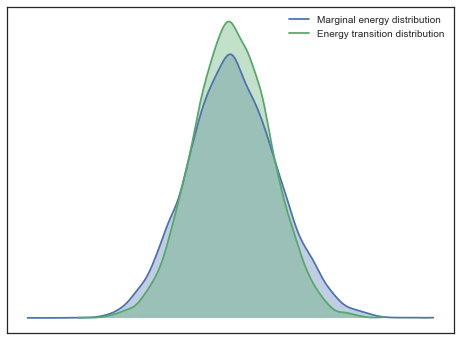

In [93]:
pm.energyplot(trace1);

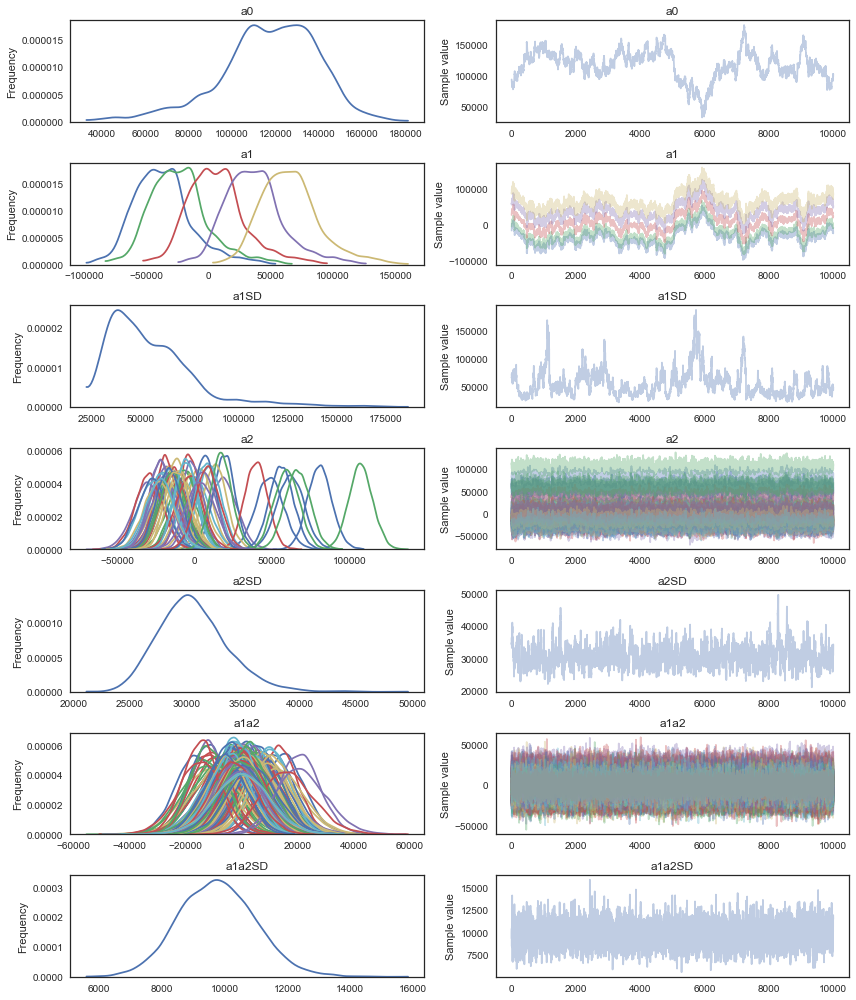

In [100]:
pm.traceplot(trace1, varnames=['a0', 'a1', 'a1SD', 'a2', 'a2SD', 'a1a2', 'a1a2SD']);

In [95]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, n_samples))
b1b2 = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace1['a0'] +
                     trace1['a1'][:,j1] +
                     trace1['a2'][:,j2] +
                     trace1['a1a2'][:,j1,j2])

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

# Below are the values corresponding to the first column of table 20.2
print('b0: {}'.format(np.round(np.mean(b0))))
print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
print('b2: {}'.format(np.round(np.mean(b2, axis=1))[[20,48,12,7]]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,12]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,12]))
print('ySigma: {}'.format(np.round(np.mean(trace1['ySigma']))))

b0: 127052.0
b1: [-46340. -33057.  -3128.  27041.  55484.]
b2: [ -19394.    6759.   19221.  109194.]
b1b2: -3350.0
b1b2: -15155.0
b1b2: -12831.0
b1b2: 12985.0
ySigma: 17979.0


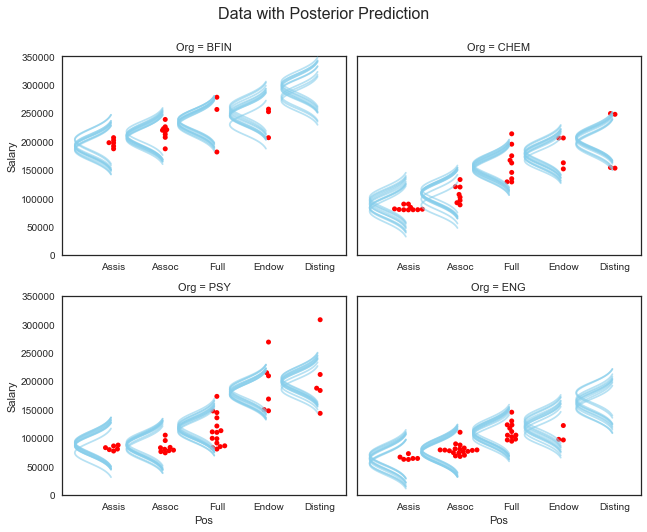

In [96]:
burnin = 200
scale = trace1['ySigma']

# Figure 20.8 in the book shows the Salary data for four of the sixty departments.
# Let's create the subset for plotting. 
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]

fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org,
                   col_wrap=2, size=3.5, aspect=1.3, despine=False, sharex=False) 
fg.map(sns.swarmplot, 'Pos', 'Salary', data=subset_df, color='r')
fg.fig.suptitle('Data with Posterior Prediction', y=1.05, fontsize=16)
for ax in fg.axes:
    ax.set_xlim(xmin=-1)
    ax.set_ylim((0,350000))
    
for i, org_idx in enumerate([7,12,48,20]):
    for pos_idx in np.arange(5):
        plot_mustache(b0[burnin:]+
                      b1[pos_idx, burnin:]+
                      b2[org_idx,burnin:]+
                      b1b2[pos_idx,org_idx,burnin:], scale[burnin:], pos_idx, ax=fg.axes.flatten()[i])

### 20.2.3 - Main effect contrasts

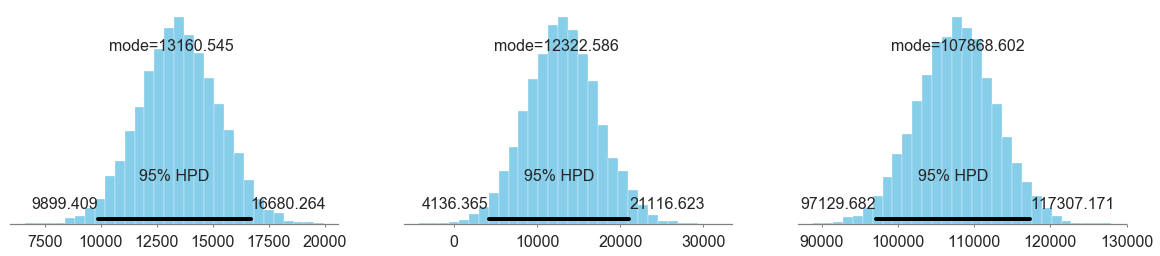

In [97]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,4))

pm.plot_posterior((b1[1,burnin:])-(b1[0,burnin:]), color=color, point_estimate='mode', ax=ax1)
pm.plot_posterior(b2[12,burnin:]-b2[48,burnin:], color=color, point_estimate='mode', ax=ax2)
pm.plot_posterior(b2[7,burnin:]-np.mean([b2[48,burnin:],
                                          b2[12,burnin:],
                                          b2[20,burnin:]], axis=0), color=color, point_estimate='mode', ax=ax3);

### 20.4 - Heterogenous Variances and Robustness against Outliers

#### Model (Kruschke, 2015)

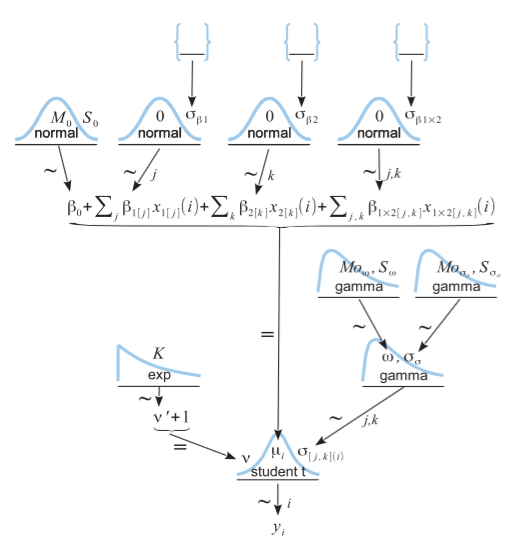

In [8]:
Image('images/fig20_7.png')

In [ ]:
a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    
    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    
    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    
    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))

In [101]:
y = df.Salary

yMean = y.mean()
ySD = y.std()
aGammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD )

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

cellSDs = df.groupby(['Org','Pos']).std().dropna()
medianCellSD = cellSDs.median().squeeze()
sdCellSD = cellSDs.std().squeeze()
sgammaShRa = gammaShRaFromModeSD(medianCellSD, 2*sdCellSD)

with pm.Model() as model2:
        
    #a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0, sd=1)
    a0 = pm.Deterministic('a0', yMean + ySD*5*a0_tilde)
        
    a1SD = pm.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    #a1 = pm.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a1_tilde = pm.Normal('a1_tilde', mu=0, sd=1, shape=Nx1Lvl)
    a1 = pm.Deterministic('a1', 0.0 + a1SD*a1_tilde)
    
    a2SD = pm.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    #a2 = pm.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    a2_tilde = pm.Normal('a2_tilde', mu=0, sd=1, shape=Nx2Lvl)
    a2 = pm.Deterministic('a2', 0.0 + a2SD*a2_tilde)
        
    a1a2SD = pm.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    #a1a2 = pm.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
    a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sd=1, shape=(Nx1Lvl, Nx2Lvl))
    a1a2 = pm.Deterministic('a1a2', 0.0 + a1a2SD*a1a2_tilde)
    
    mu = a0 + a1[x1] + a2[x2] +a1a2[x1, x2]
             
    sigmaMode = pm.Gamma('sigmaMode', sgammaShRa[0], sgammaShRa[1]) 
    sigmaSD = pm.Gamma('sigmaSD', sgammaShRa[0], sgammaShRa[1]) 
    sigmaRa = pm.Deterministic('sigmaRa', (sigmaMode + tt.sqrt(sigmaMode**2 + 4*sigmaSD**2)) / (2*sigmaSD**2))
    sigmaSh = pm.Deterministic('sigmaSh', (sigmaMode * sigmaRa))
    sigma = pm.Gamma('sigma', sigmaSh, sigmaRa, shape=(Nx1Lvl, Nx2Lvl))
    ySigma = pm.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
          
    nu = pm.Exponential('nu', 1/30.)
        
    like = pm.StudentT('like', nu, mu, sd=ySigma[x1, x2], observed=y)    

In [102]:
n_samples = 1000
with model2:
    trace2 = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
INFO (theano.gof.compilelock): Refreshing lock /Users/jordi/.theano/compiledir_Darwin-16.6.0-x86_64-i386-64bit-i386-3.5.3-64/lock_dir/lock
Average Loss = 12,097:  23%|██▎       | 45454/200000 [00:33<01:53, 1363.92it/s]
Convergence archived at 45500
Interrupted at 45,500 [22%]: Average Loss = 13,081
INFO (theano.gof.compilelock): Refreshing lock /Users/jordi/.theano/compiledir_Darwin-16.6.0-x86_64-i386-64bit-i386-3.5.3-64/lock_dir/lock
100%|██████████| 1500/1500 [21:27<00:00,  1.08it/s]/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



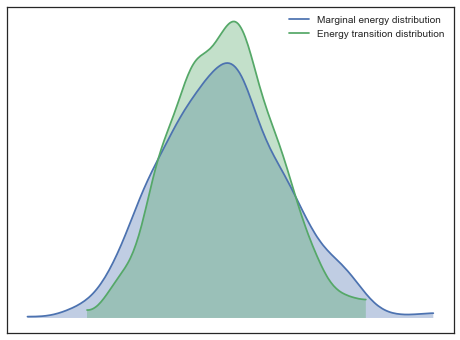

In [106]:
pm.energyplot(trace2)

In [104]:
# Transforming the trace data to sum-to-zero values
m = np.zeros((Nx1Lvl,Nx2Lvl, n_samples))
b1b2 = m.copy()
sigma = m.copy()

for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        m[j1,j2] =  (trace2['a0'] +
                     trace2['a1'][:,j1] +
                     trace2['a2'][:,j2] +
                     trace2['a1a2'][:,j1,j2])
        sigma[j1,j2] = trace2['ySigma'][:,j1,j2]

b0 = np.mean(m, axis=(0,1))
b1 = np.mean(m, axis=1) - b0
b2 = np.mean(m, axis=0) - b0
        
for (j1,j2) in np.ndindex(Nx1Lvl,Nx2Lvl):
        b1b2[j1,j2] =  (m[j1,j2] - (b0 + b1[j1] + b2[j2]))

print('b0: {}'.format(np.round(np.mean(b0))))
print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
print('b2: {}'.format(np.round(np.mean(b2, axis=1), decimals=3)[[20,48,12,7]]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[0,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[2,48]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[0,12]))
print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2), decimals=3)[2,12]))

b0: 123305.0
b1: [-41982. -29660.  -2528.  22686.  51484.]
b2: [ -16452.945   -3504.466    9912.884  116227.027]
b1b2: 3583.903
b1b2: -2905.594
b1b2: -8330.711
b1b2: 4454.343


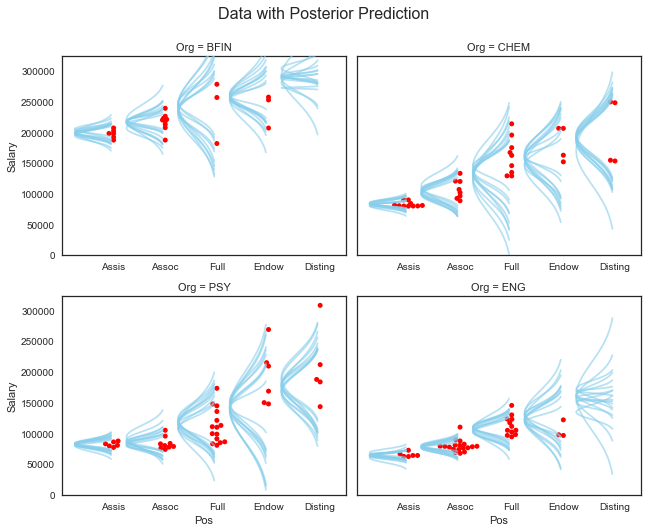

In [105]:
burnin = 20
scale = sigma

# Figure 20.8 in the book shows the Salary data for four of the sixty departments.
# Let's create the subset for plotting. 
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]

fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org,
                   col_wrap=2, size=3.5, aspect=1.3, despine=False, sharex=False) 
fg.map(sns.swarmplot, 'Pos', 'Salary', data=subset_df, color='r')
fg.fig.suptitle('Data with Posterior Prediction', y=1.05, fontsize=16)
for ax in fg.axes:
    ax.set_xlim(xmin=-1)
    ax.set_ylim(ymin=0)
    
for i, org_idx in enumerate([7,12,48,20]):
    for pos_idx in np.arange(5):
        plot_mustache(b0[burnin:]+
                      b1[pos_idx, burnin:]+
                      b2[org_idx, burnin:]+
                      b1b2[pos_idx,org_idx,burnin:], sigma[pos_idx, org_idx, burnin:], pos_idx, ax=fg.axes.flatten()[i])

### 20.5.2 - Split-plot design

In [34]:
df2 = pd.read_csv('data/SplitPlotAgriData.csv')
df2.Field = df2.Field.astype('category')
df2.Till = df2.Till.astype('category')
df2.Fert = df2.Fert.astype('category')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
Field    99 non-null category
Till     99 non-null category
Fert     99 non-null category
Yield    99 non-null int64
dtypes: category(3), int64(1)
memory usage: 2.9 KB


In [35]:
df2.head()

,Field,Till,Fert,Yield
0,1,Chisel,Broad,119
1,1,Chisel,Deep,130
2,1,Chisel,Surface,123
3,2,Chisel,Broad,135
4,2,Chisel,Deep,148


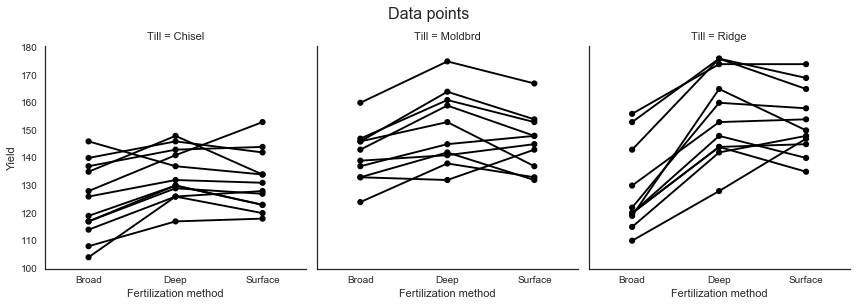

In [36]:
g = sns.FacetGrid(df2, col='Till', hue='Field', size=4)
g.map(sns.pointplot, 'Fert', 'Yield', color='k', scale=0.6)

for ax in g.axes.flatten():
    ax.set_xlabel('Fertilization method')
    
g.fig.suptitle('Data points', y=1.05, fontsize=16);

#### Model

In [115]:
# Tilling method
xBetween = df2.Till.cat.codes.values
xBetweenLvl = df2.Till.cat.categories
NxBetweenLvl = len(xBetweenLvl)

# Fertilization method
xWithin = df2.Fert.cat.codes.values
xWithinLvl = df2.Fert.cat.categories
NxWithinLvl = len(xWithinLvl)

# Individual fields
xSubject = df2.Field.cat.codes.values
xSubjectLvl = df2.Field.cat.categories
NxSubjectLvl = len(xSubjectLvl)

# Yield
y = df2.Yield
yMean = y.mean()
ySD = y.std()

agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model3:
    
    # Baseline Yield
    #a0 = pm.Normal('a0', mu=yMean, tau=1/(ySD*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0.0, sd=1)
    a0 = pm.Deterministic('a0', 0.0 +ySD*5*a0_tilde)
    
    # Yield deflection from baseline for tilling method
    sigmaB = pm.Gamma('sigmaB', agammaShRa[0], agammaShRa[1])
    #aB = pm.Normal('aB', mu=0.0, tau=1/sigmaB**2, shape=NxBetweenLvl)
    aB_tilde = pm.Normal('aB_tilde', mu=0.0, sd=1, shape=NxBetweenLvl)
    aB = pm.Deterministic('aB', 0.0 + sigmaB*aB_tilde)
    
    # Yield deflection from baseline for fertilization method
    sigmaW = pm.Gamma('sigmaW', agammaShRa[0], agammaShRa[1])
    #aW = pm.Normal('aW', mu=0.0, tau=1/sigmaW**2, shape=NxWithinLvl)
    aW_tilde = pm.Normal('aW_tilde', mu=0.0, sd=1, shape=NxWithinLvl)
    aW = pm.Deterministic('aW', 0.0 + sigmaW*aW_tilde)
    
    # Yield deflection from baseline for combination of tilling and fertilization method
    sigmaBxW = pm.Gamma('sigmaBxW', agammaShRa[0], agammaShRa[1])
    #aBxW = pm.Normal('aBxW', mu=0.0, tau=1/sigmaBxW**2, shape=(NxBetweenLvl, NxWithinLvl))
    aBxW_tilde = pm.Normal('aBxW_tilde', mu=0.0, sd=1, shape=(NxBetweenLvl, NxWithinLvl))
    aBxW = pm.Deterministic('aBxW', 0.0 + sigmaBxW*aBxW_tilde)
    
    # Yield deflection from baseline for individual fields
    sigmaS = pm.Gamma('sigmaS', agammaShRa[0], agammaShRa[1])
    #aS = pm.Normal('aS', mu=0.0, tau=1/sigmaS**2, shape=NxSubjectLvl)
    aS_tilde = pm.Normal('aS_tilde', mu=0.0, sd=1, shape=NxSubjectLvl)
    aS = pm.Deterministic('aS', 0.0 + sigmaS*aS_tilde)
    
    sigma = pm.Uniform('sigma', ySD/100, ySD*10)
    mu = a0 + aB[xBetween] + aW[xWithin] + aBxW[xBetween, xWithin] + aS[xSubject] 
    
    like = pm.Normal('like', mu=mu, tau=1/sigma**2, observed=y)

In [119]:
with model3:
    trace3 = pm.sample(5000, nuts_kwargs={'target_accept':.97})

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 429.08:  11%|█         | 22295/200000 [00:05<00:47, 3706.86it/s]
Convergence archived at 22600
Interrupted at 22,600 [11%]: Average Loss = 516.13
100%|█████████▉| 5499/5500 [06:28<00:00, 13.97it/s]/Users/jordi/anaconda/envs/probalistic/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 4 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 5500/5500 [06:29<00:00, 14.14it/s]


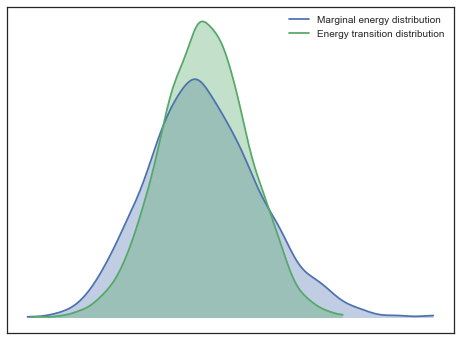

In [120]:
pm.energyplot(trace3);

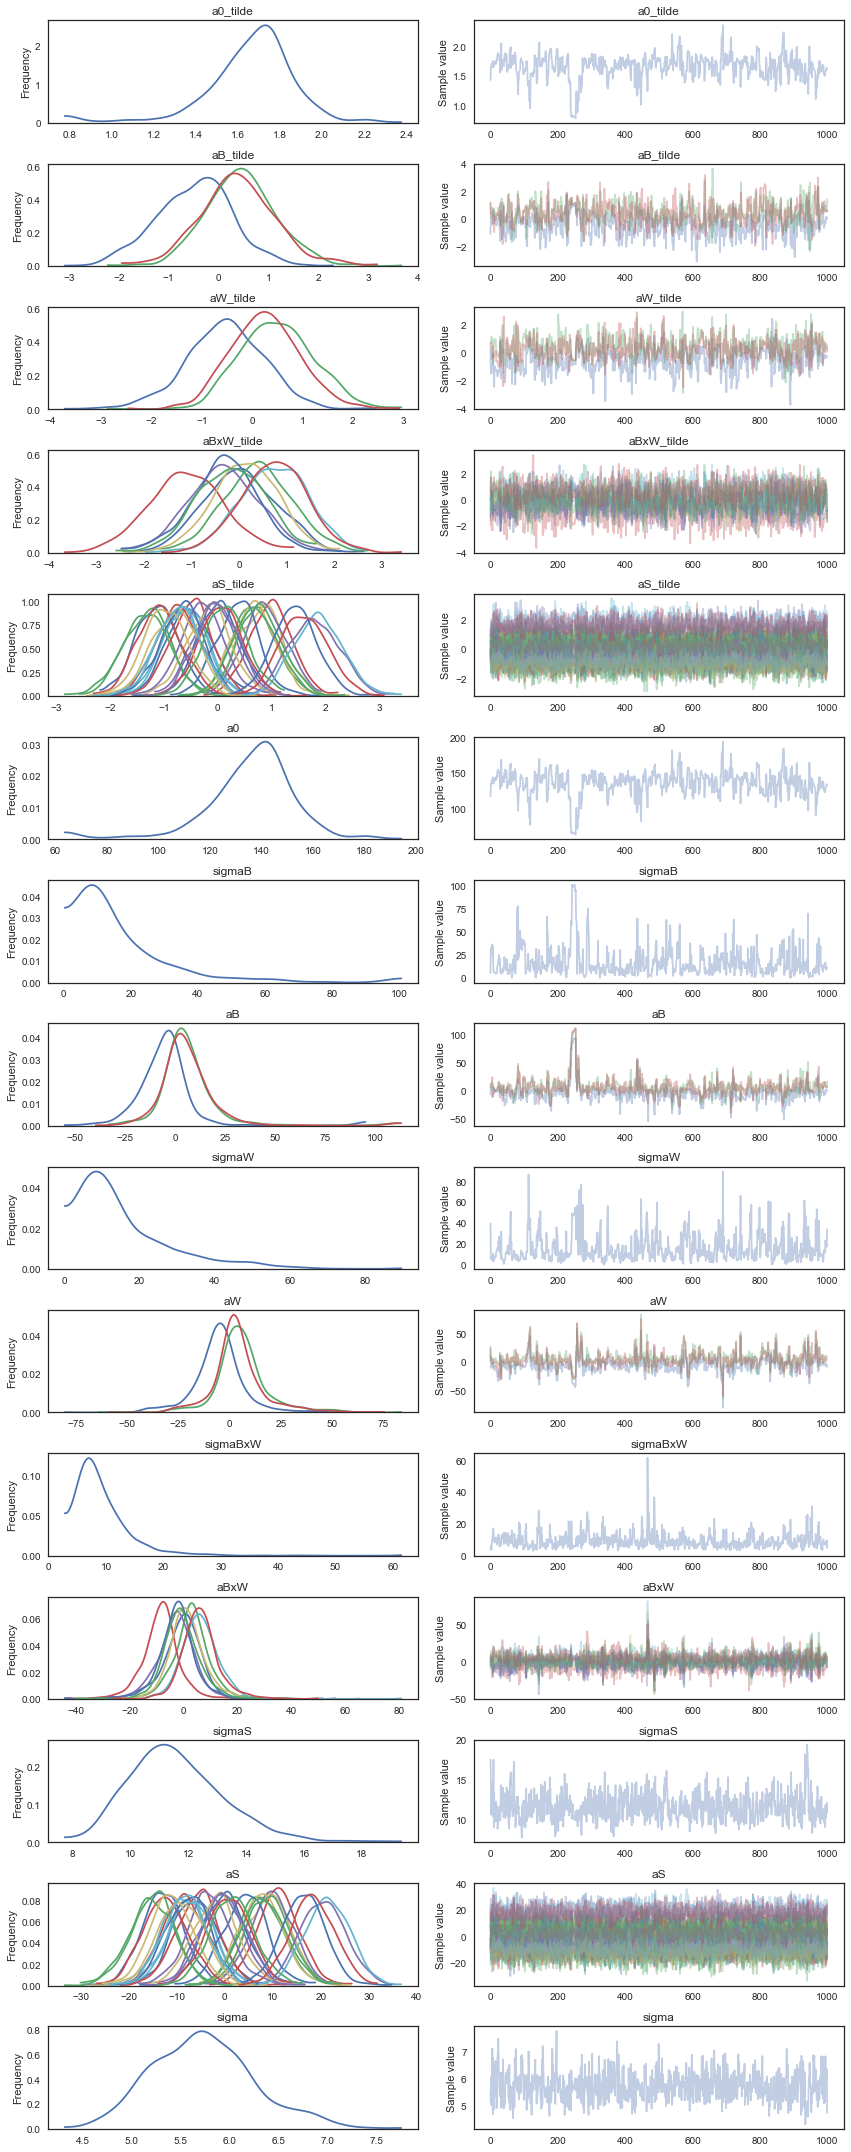

In [118]:
pm.traceplot(trace3);

In [40]:
a0 = trace3['a0']
aB = trace3['aB']
aW = trace3['aW']
aBxW = trace3['aBxW']
aS = trace3['aS']
sigma = trace3['sigma']

### Marginal means and sum-to-zero deflections

In contrast to the JAGS code from the book, we recenter the deflections after sampling. That is why there is an extra dimension containing all trace values.  

Let's put all the cell values in a multi-dimensional array.
- Axis 0: SubjectLvl S (Field)
- Axis 1: BetweenLvl B (Tilling method)
- Axis 2: WithinLvl W (Fertilization method)
- Axis 3: The corresponding mu values for the entire trace

We can use Numpy masked arrays, with the values '0' being masked. This helps with calculating means along the different axes: masked values (= empty cells) are not taken into account. This is important since there are different number of Fields for each Tilling method.

In [41]:
# Initialize the array with zeros
mSxBxW = np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl, len(trace3)))

# Fill the arrray
for k, i, j in zip(xSubject, xBetween, xWithin):
    mu = a0 + aB[:,i] + aW[:,j] + aBxW[:,i,j] + aS[:,k]
    mSxBxW[k,i,j,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
mSxBxW_ma.shape

(33, 3, 3, 5000)

#### Calculating the means

In [42]:
# Mean for subject S across levels of W, within the level of B
mS = ma.mean(mSxBxW_ma, axis=(2))
mS.data.shape

(33, 3, 5000)

In [43]:
# Mean for treatment combination BxW, across subjects S
mBxW = mSxBxW_ma.mean(axis=(0))
mBxW.data.shape

(3, 3, 5000)

In [44]:
# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
mB.data.shape

(3, 1, 5000)

In [45]:
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
mW.shape

(1, 3, 5000)

#### Converting to sum-to-zero

In [46]:
# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
print('Mean baseline yield: {}'.format(b0.mean()))

Mean baseline yield: 140.42445891209115


In [47]:
# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m
print('Mean yield deflection from baseline for tilling method:')
pd.DataFrame(bB.data.mean(1), index=xBetweenLvl, columns=['Deflection'])

Mean yield deflection from baseline for tilling method:


,Deflection
Chisel,-10.531486
Moldbrd,5.447799
Ridge,5.083687


In [48]:
# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m
print('Mean yield deflection from baseline for fertilization method:')
pd.DataFrame(bW.data.mean(1), index=xWithinLvl, columns=['Deflection'])

Mean yield deflection from baseline for fertilization method:


,Deflection
Broad,-9.350201
Deep,6.209054
Surface,3.141147


In [49]:
# Equation 20.6
bBxW = mBxW - mB - mW + m
print('Mean yield deflection from baseline for tilling-fertilization combination:')
pd.DataFrame(bBxW.data.mean(2), index=xBetweenLvl, columns=xWithinLvl)

Mean yield deflection from baseline for tilling-fertilization combination:


,Broad,Deep,Surface
Chisel,3.604947,-2.224071,-1.380876
Moldbrd,4.065337,-1.202963,-2.862374
Ridge,-7.670284,3.427034,4.243250


In [50]:
# Equation 20.7
bS = mS - mB.squeeze()
print('Mean yield deflection from baseline for individual fields:')
pd.DataFrame(bS.mean(2).compressed(), index=xSubjectLvl, columns=['Deflection'])

Mean yield deflection from baseline for individual fields:


,Deflection
1,-5.216395
2,8.382584
3,11.872388
4,-0.157139
5,9.999225
6,-5.924639
7,-12.109880
8,-14.123547
9,-5.133833
10,10.536260


#### Figure 20.10

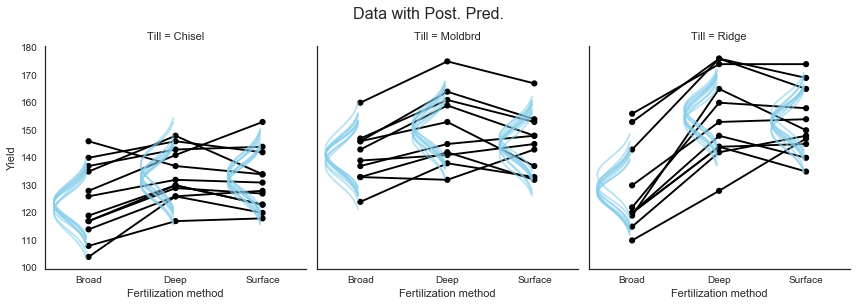

In [51]:
g = sns.FacetGrid(df2, col='Till', hue='Field', size=4)
g.map(sns.pointplot, 'Fert', 'Yield', color='k', scale=0.6)

# Above we found the mean values for the different deflections. Here we plot the
# full posteriors of the yield given tilling and fertilization method.
for i, j in np.ndindex(NxBetweenLvl, NxWithinLvl):
    plot_mustache(b0+
                  bB[i,:]+
                  bW[j,:]+
                  bBxW[i,j,:],
                  sigma,
                  j, width= 0.4, ax=g.axes.flatten()[i])

for ax in g.axes.flatten():
    ax.set_xlabel('Fertilization method')
    
g.fig.suptitle('Data with Post. Pred.', y=1.05, fontsize=16);

### Contrasts
#### Figure 20.11

In [52]:
# The posteriors for the main contrasts can be calculated directly from the parameters.
# The posterior for the interaction contrast (rightmost plot) however, is calculated as follows.
# [Chisel & Moldbrd] vs [Ridge]
B = np.asarray([-.5, -.5, 1])
# [Broad] vs [Deep & Surface]
W = np.asarray([-1, .5, .5])
# The signs in the above vectors can be flipped, the end result (posterior) will be the same.
# Using the outer product of these two vectors, we get the matrix we need to multiply
# with the trace values of bBxW.
ic_factors = np.outer(B,W)
pd.DataFrame(ic_factors, index=xBetweenLvl, columns=xWithinLvl)

,Broad,Deep,Surface
Chisel,0.5,-0.25,-0.25
Moldbrd,0.5,-0.25,-0.25
Ridge,-1.0,0.50,0.50


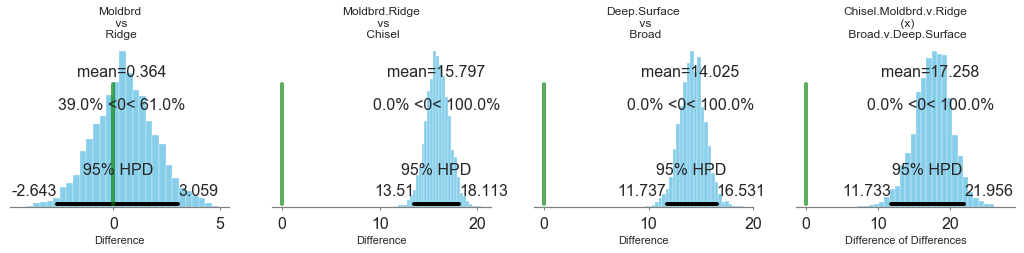

In [53]:
contrasts = [bB[1,:]-bB[2,:],
             ma.mean(bB[1:,:], axis=0) - bB[0,:],
             ma.mean(bW[1:,:], axis=0) - bW[0,:],
             np.tensordot(ic_factors, bBxW)]

titles = ['Moldbrd\n vs\n Ridge',
          'Moldbrd.Ridge\n vs\n Chisel',
          'Deep.Surface\n vs\n Broad',
          'Chisel.Moldbrd.v.Ridge\n (x)\n Broad.v.Deep.Surface']

xlabels = ['Difference']*3 + ['Difference of Differences']

fig, axes = plt.subplots(1,4, figsize=(18,3))

for c, t, l, ax in zip(contrasts, titles, xlabels, axes):
    pm.plot_posterior(c, point_estimate='mean', ref_val=0, color=color, ax=ax)
    ax.set_title(t)
    ax.set_xlabel(l)